# Visualize the Response from the HUC Feature Translation Service

Below I've provided some examples of how to visualize the response from the Feature Translation Service. As of now, without support from the Earthdata search client, there's no easy way to glean whether your response _is_ indeed correct. So, here I provide code that takes a response from the HUC Feature Translation Service, and graphs the associated bounding boxes, convex hull polygons, and Visvalingam-Whyatt polygons.

In [1]:
%%capture

import sys
!{sys.executable} -m pip install geopandas pandas requests shapely numpy

In [2]:
from shapely.geometry import box, Polygon
import matplotlib.pyplot as plt 
import geopandas as gpd
import numpy as np
import requests
import json
import math

## Function for Visualization

Below is a function I've created specifically to visualize the output of the HUC Feature Translation Service. 

In [3]:
def visualize(fts_response):
    
    regions = []
    bounding_boxes = []
    convex_hull_polygons = []
    visvalingam_polygons = []
    for element in fts_response['results']:
        for heading in fts_response['results'][element]:
            if heading == "Bounding Box":
                bounding_boxes.append([float(e) for e in fts_response['results'][element][heading].split(",")])
            elif heading == "Convex Hull Polygon":
                convex_hull_polygons.append([float(e) for e in fts_response['results'][element][heading].split(",")])
            elif heading == "Visvalingam Polygon":
                visvalingam_polygons.append([float(e) for e in fts_response['results'][element][heading].split(",")])
            elif heading == "HUC":
                regions.append("Region Name: " + element + "\n" + "HUC: " + fts_response['results'][element][heading])
            elif heading == "Region":
                regions.append("Region Name: " + fts_response['results'][element][heading] + "\n" + "HUC: " + element)
            else:
                continue

    bounding_boxes = [box(e[0], e[1], e[2], e[3]) for e in bounding_boxes]
    convex_hull_polygons = [Polygon(np.asarray(polygon).reshape(-1,2)) for polygon in convex_hull_polygons]
    visvalingam_polygons = [Polygon(np.asarray(polygon).reshape(-1,2)) for polygon in visvalingam_polygons]
    
    for i in range(len(bounding_boxes)):
        ax = gpd.GeoSeries(bounding_boxes[i]).plot(alpha=0.2, cmap='Pastel1', figsize=(10,10))
        gpd.GeoSeries(convex_hull_polygons[i]).plot(ax = ax, cmap='Pastel2')
        gpd.GeoSeries(visvalingam_polygons[i]).plot(alpha=0.5, ax=ax, cmap='viridis')

        plt.title(regions[i])
        plt.show()
            

## Query HUC Feature Translation Service

Below I've queried the HUC portion of the Feature Translation Service using one of the seven examples from the previous _HUC Feature Translation Service Examples_ notebook.

In [4]:
###################

# Mimicing a user querying partial matches with region "California"
# This "partial" match is anything that BEGINS with the region specified.

REGION = "California R"
EXACT = False

###################

# Query Feature Translation Service and parse JSON response
r = requests.get("https://g6zl7z2x7j.execute-api.us-west-2.amazonaws.com/prod/region/{}?exact={}".format(REGION, EXACT))

# Load response from FTS
response = json.loads(r.text)

# Print all elements in HUC database that partially matches with HUC 1805000301
print(json.dumps(response, indent = 4))

{
    "status": "200 OK",
    "hits": 2,
    "time": "1.91 ms.",
    "search on": {
        "parameter": "region",
        "exact": false
    },
    "results": {
        "California Region": {
            "HUC": "18",
            "Bounding Box": "-124.53512390463686,32.13300128241485,-114.61976870231916,43.342727509806764",
            "Convex Hull Polygon": "-115.97134255334623,32.13300128241485,-115.91523592010003,32.137604250116055,-115.91480779614233,32.137673303240945,-115.91431062010145,32.13776997719913,-114.97159458302303,32.503444622464826,-114.90724580812292,32.532873271377525,-114.9046643466686,32.534375214083525,-114.86730357172661,32.55972046300252,-114.86580163006226,32.56108159737539,-114.74952303961777,32.68152488260512,-114.74886226774379,32.68251214822857,-114.74055270421502,32.705498061734545,-114.71266390113328,32.97096115715584,-114.61976870231916,33.92126755151412,-114.63726287625036,34.02433291385415,-114.80367341765873,34.76481408874645,-114.8038173759918,34.765

## Visualization

I can take that response and pass it to the _visualize()_ function created above. 

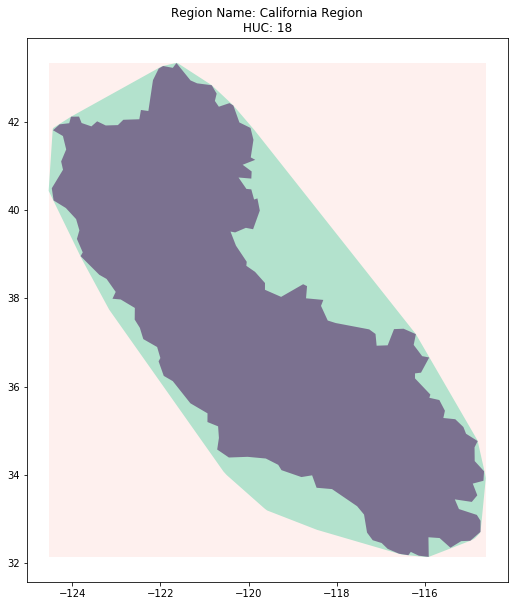

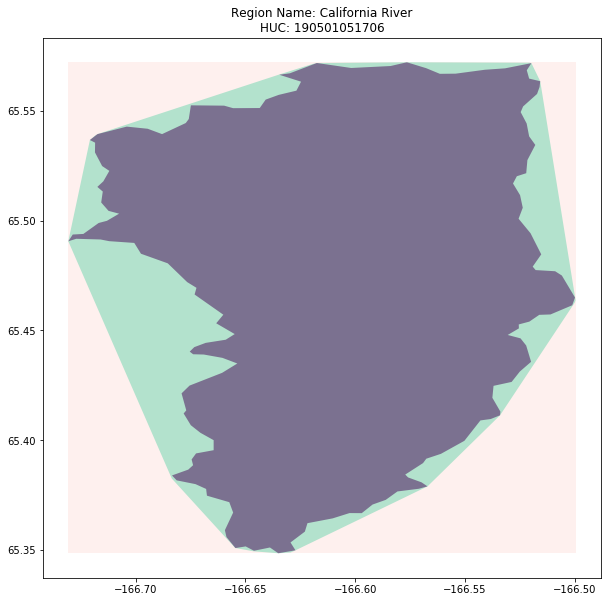

In [5]:
visualize(response)